In [1]:
# !pip install transformers # done


In [2]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli")
sequence_to_classify = "Angela Merkel is a politician in Germany and leader of the CDU"
candidate_labels = ["politics", "economy", "entertainment", "environment"]
output = classifier(sequence_to_classify, candidate_labels, multi_label=False)
print(output)

{'sequence': 'Angela Merkel is a politician in Germany and leader of the CDU', 'labels': ['politics', 'environment', 'economy', 'entertainment'], 'scores': [0.9967535734176636, 0.0014776686439290643, 0.0012541556498035789, 0.0005145781906321645]}


In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from transformers import pipeline

In [4]:
# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
### This code-cell took way too long to load for some reason
device = "cpu"

model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)


In [5]:
eg1_p, eg1_h = "Inflation in Venezuela", "High prices in Venezuela"#"He snored", "He slept"
eg2_p, eg2_h = "The sun will shine", "Rain Falls"
eg3_p, eg3_h= "the bank of japan appealed to financial markets to remain calm friday following the us decision to order daiwa bank ltd. to close its us operations .", "daiwa bank ltd. to close its us operations"

premise, hypothesis = eg3_p, eg3_h#eg1_p, eg1_h

input = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt")
output = model(input["input_ids"].to(device))  # device = "cuda:0" or "cpu"
prediction = torch.softmax(output["logits"][0], -1).tolist()
label_names = ["entailment", "neutral", "contradiction"]
prediction = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
print(prediction)


{'entailment': 98.6, 'neutral': 1.0, 'contradiction': 0.3}


Let's change everything to functions

In [6]:
from tqdm import tqdm
def load_model():
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model_name = "MoritzLaurer/DeBERTa-v3-large-mnli-fever-anli-ling-wanli"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)
    return tokenizer, model, device

def classify_nli(tokenizer, model, device, premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    prediction = torch.softmax(outputs.logits, dim=-1)[0]
    label_names = ["entailment", "neutral", "contradiction"]
    prediction_scores = {name: round(float(pred) * 100, 1) for pred, name in zip(prediction, label_names)}
    predicted_label = label_names[torch.argmax(prediction)]
    return predicted_label, prediction_scores

def process_file(input_file, output_file):
    tokenizer, model, device = load_model()
    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        lines = infile.readlines()
        for line in tqdm(lines, desc="Processing pairs"):
            premise, hypothesis = line.strip().split("\t")
            predicted_label, prediction_scores = classify_nli(tokenizer, model, device, premise, hypothesis)
            outfile.write(f"{premise}\t{hypothesis}\t{predicted_label}\t{prediction_scores}\n")


NLI annotation for 30 examples:

In [7]:
if __name__ == "__main__":
    input_file = "D:\\Desktop\\master_scientific_computing\\second_semester\\problems with data\\Problems-With-Data--Summer-2024\\exercise-2\\task2-3\\toannotate.txt"
    output_file = "nli_results.txt"
    process_file(input_file, output_file)


Processing pairs: 100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


NLI annotation for the entire dataset:

In [8]:
if __name__ == "__main__":
    input_file = "alignedtest.txt"
    output_file = "nli_results_whole_dataset.txt"
    process_file(input_file, output_file)

Processing pairs: 100%|██████████| 1951/1951 [07:54<00:00,  4.12it/s]


### Binary predictions:

In [9]:
### We will use Aharoni et al 2022 and generate binary label Entailement or Non-Entailement (contradiction/neutral)
### if entailment score > both neutral score and contradiction score, then label it as E otherwise NE
def generate_binary_predictions(input_file, output_file):
    with open(input_file, "r") as infile, open(output_file, "w") as outfile:
        for line in infile:
            premise, hypothesis, predicted_label, prediction_scores_str = line.strip().split("\t")
            prediction_scores = eval(prediction_scores_str)
            entailment_score = prediction_scores['entailment']
            neutral_score = prediction_scores['neutral']
            contradiction_score = prediction_scores['contradiction']
            
            if entailment_score > neutral_score and entailment_score > contradiction_score:
                binary_label = "E"
            else:
                binary_label = "NE"
            
            outfile.write(f"{premise}\t{hypothesis}\t{binary_label}\n")

# Example usage:
input_file = "nli_results.txt"
output_file = "nli_binary_predictions.txt"
generate_binary_predictions(input_file, output_file)


### Let's compare it against our manual annotations

In [10]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import json

import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
def load_annotations(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            premise, hypothesis, annotation = line.strip().split("\t")
            data.append((premise, hypothesis, annotation))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Annotation"])

def load_nli_results(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            parts = line.strip().split("\t")
            premise, hypothesis, predicted_label = parts[0], parts[1], parts[2]
            # Try to parse the prediction_scores, ensure it's a proper JSON format
            try:
                prediction_scores = json.loads(parts[3].replace("'", "\""))  # Ensure double quotes for JSON
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON for line: {line}")
                continue
            data.append((premise, hypothesis, predicted_label, prediction_scores))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Predicted_Label", "Prediction_Scores"])


def load_nli_binary_predictions(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            premise, hypothesis, binary_label = line.strip().split("\t")
            data.append((premise, hypothesis, binary_label))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Predicted_Label_2_Class"])


def convert_to_2_class(label):
    return "E" if label == "entailment" else "NE"

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



In [12]:
def load_binary_predictions(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            premise, hypothesis, binary_label = line.strip().split("\t")
            data.append((premise, hypothesis, binary_label))
    return pd.DataFrame(data, columns=["Premise", "Hypothesis", "Predicted_Label_2_Class"])

def evaluate_annotations_vs_nli(annotations_df, nli_df):
    # Merge annotations and NLI results on premise and hypothesis
    merged_df = pd.merge(annotations_df, nli_df, on=["Premise", "Hypothesis"])
    
    # Compute confusion matrix and evaluation metrics
    y_true = merged_df["Annotation"]
    y_pred = merged_df["Predicted_Label_2_Class"]
    
    cm = confusion_matrix(y_true, y_pred, labels=["E", "NE"])
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=["E", "NE"], average=None)
    
    return cm, precision, recall, f1

Confusion Matrix:
[[14  1]
 [ 9  6]]
Precision: [0.60869565 0.85714286]
Recall: [0.93333333 0.4       ]
F1 Score: [0.73684211 0.54545455]


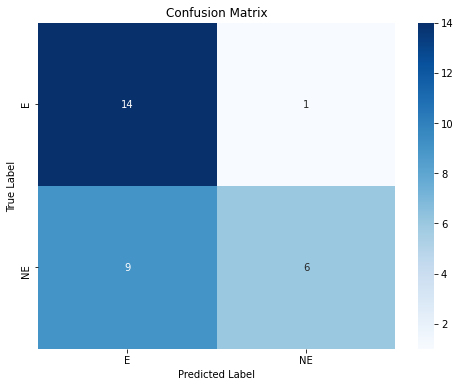

In [16]:
def main():
    annotations_file = "toannotate_Neelkanth_Rawat.txt"#"D:\\Desktop\\master_scientific_computing\\second_semester\\problems with data\\Problems-With-Data--Summer-2024\\exercise-2\\task2-3\\toannotate_Neelkanth_Rawat.txt"
    nli_binary_predictions_file = "nli_binary_predictions.txt"

    annotations_df = load_annotations(annotations_file)
    nli_df = load_binary_predictions(nli_binary_predictions_file)

    cm, precision, recall, f1 = evaluate_annotations_vs_nli(annotations_df, nli_df)
    print("Confusion Matrix:")
    print(cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    
    plot_confusion_matrix(cm, labels=["E", "NE"])

if __name__ == "__main__":
    main()


Task 3.3

In [14]:
### generating binary NLI annotations for the entire dataset (need for task 3.3)
input_all_nli= "nli_results_whole_dataset.txt"
output_nli_binary = "nli_whole_dataset_binary_preds.txt"
generate_binary_predictions(input_all_nli, output_nli_binary)

In [15]:
# Filename of your data file
filename = 'nli_whole_dataset_binary_preds.txt'

# Initialize counters
count_E = 0
count_NE = 0

# Read the file
with open(filename, 'r', encoding='utf-8') as file:
    for line in file:
        # Split the line by tabspace to get the label
        parts = line.strip().split('\t')
        if len(parts) == 3:
            label = parts[2]
            if label == 'E':
                count_E += 1
            elif label == 'NE':
                count_NE += 1

# Print the counts
print(f"Number of 'E' (Entailed) labels: {count_E}")
print(f"Number of 'NE' (Non-Entailed) labels: {count_NE}")
print(f"Overall % of NE: {(count_NE/(count_E+count_NE))*100:.2f}%")

Number of 'E' (Entailed) labels: 866
Number of 'NE' (Non-Entailed) labels: 1085
Overall % of NE: 55.61%
